In [19]:
! mkdir df

https://www.kaggle.com/flo2607/traffic-signs-classification

## **Unzipping the data**

In [20]:
! unzip archive.zip -d df

Streaming output truncated to the last 5000 lines.
  inflating: df/myData/8/00015_00010.jpg  
  inflating: df/myData/8/00015_00011.jpg  
  inflating: df/myData/8/00015_00012.jpg  
  inflating: df/myData/8/00015_00013.jpg  
  inflating: df/myData/8/00015_00014.jpg  
  inflating: df/myData/8/00015_00015.jpg  
  inflating: df/myData/8/00015_00016.jpg  
  inflating: df/myData/8/00015_00017.jpg  
  inflating: df/myData/8/00015_00018.jpg  
  inflating: df/myData/8/00015_00019.jpg  
  inflating: df/myData/8/00015_00020.jpg  
  inflating: df/myData/8/00015_00021.jpg  
  inflating: df/myData/8/00015_00022.jpg  
  inflating: df/myData/8/00015_00023.jpg  
  inflating: df/myData/8/00015_00024.jpg  
  inflating: df/myData/8/00015_00025.jpg  
  inflating: df/myData/8/00015_00026.jpg  
  inflating: df/myData/8/00015_00027.jpg  
  inflating: df/myData/8/00015_00028.jpg  
  inflating: df/myData/8/00015_00029.jpg  
  inflating: df/myData/8/00016_00000.jpg  
  inflating: df/myData/8/00016_00001.jpg  
  i

In [21]:
def img_preprocessing(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  img = img/255
  return img

## **Loading Datasets**

In [22]:
import os
import cv2
import numpy as np

dataset = os.listdir('/content/df/myData')
print("Importing datasets------------")
c=0
image_arr=[]
num_classes=[]
for classes in dataset:
  img_list = os.listdir('/content/df/myData/'+str(c))
  for files in img_list:
    img = cv2.imread('/content/df/myData/'+str(c)+'/'+files)
    image_arr.append(img)
    num_classes.append(c)
  if c%7==0:
    print(c," class imported")
  if c == 42:
    
    print('Import Successfull')
  c +=1

img_set = np.array(image_arr)
class_num = np.array(num_classes)

Importing datasets------------
0  class imported
7  class imported
14  class imported
21  class imported
28  class imported
35  class imported
42  class imported
Import Successfull


In [23]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(img_set,class_num,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)

In [24]:
X_train = np.array(list(map(img_preprocessing,X_train)))
X_val = np.array(list(map(img_preprocessing,X_val)))
X_test = np.array(list(map(img_preprocessing,X_test)))

In [25]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],1)

In [26]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             rotation_range=10,
                             horizontal_flip = False,
                             )
datagen.fit(X_train)

In [27]:
import pandas as pd

data_class = pd.read_csv('/content/df_final/labels.csv')
data_class.head()

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [28]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train,len(dataset))
y_val = to_categorical(y_val,len(dataset))
y_test = to_categorical(y_test,len(dataset))

In [29]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D

model = Sequential()
model.add(Conv2D(64,(5,5),input_shape= (32,32,1),activation='relu'))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(43,activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 32)         

In [31]:
from tensorflow.keras.optimizers import Adam

model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
import tensorflow as tf

checkpoint_dir = os.path.dirname('/content/weights.ckpt')
cp_callback = tf.keras.callbacks.ModelCheckpoint('/content/weights.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)

hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=32),steps_per_epoch=1000,epochs=10,verbose=1,callbacks=[cp_callback],validation_data=(X_val,y_val))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1000/1000 [==============================] - 51s 22ms/step - loss: 1.5830 - accuracy: 0.5457 - val_loss: 0.2496 - val_accuracy: 0.9224

Epoch 00001: saving model to /content/weights.ckpt
Epoch 2/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.5712 - accuracy: 0.8246 - val_loss: 0.1158 - val_accuracy: 0.9689

Epoch 00002: saving model to /content/weights.ckpt
Epoch 3/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.3844 - accuracy: 0.8807 - val_loss: 0.0743 - val_accuracy: 0.9792

Epoch 00003: saving model to /content/weights.ckpt
Epoch 4/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.2995 - accuracy: 0.9061 - val_loss: 0.0498 - val_accuracy: 0.9852

Epoch 00004: saving model to /content/weights.ckpt
Epoch 5/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.2587 - accuracy: 0.9193 - val_loss: 0.0429 - val_accuracy: 0.9885

Epoch 00005: saving model to /content/weights.ckpt
Epoch 6/10

# **Test Accuracy**

In [33]:
score = model.evaluate(X_test,y_test,verbose=1)

458/458 [==============================] - 3s 6ms/step - loss: 0.0313 - accuracy: 0.9906


In [34]:
accuracy = score[1]
print("The model have a test accuracy of {:.3f}%".format(accuracy*100))

The model have a test accuracy of 99.063%


## **Plots**

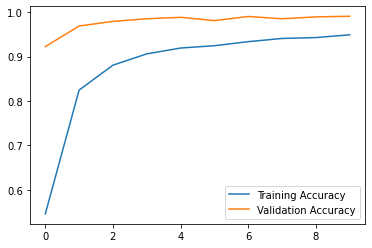

In [35]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

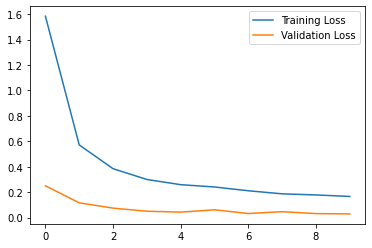

In [36]:
plt.plot(hist.history['loss'],label ='Training Loss')
plt.plot(hist.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        79
           1       0.98      0.99      0.98       960
           2       0.99      0.95      0.97       521
           3       0.98      0.99      0.99       542
           4       0.99      0.99      0.99       724
           5       1.00      0.94      0.97       720
           6       1.00      1.00      1.00       178
           7       0.95      0.99      0.97       575
           8       0.99      0.98      0.98       549
           9       0.99      1.00      1.00       550
          10       1.00      1.00      1.00       772
          11       1.00      1.00      1.00       522
          12       1.00      1.00      1.00       782
          13       1.00      1.00      1.00       814
          14       1.00      1.00      1.00       289
          15       1.00      0.96      0.98       246
          16       1.00      1.00      1.00       147
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
